In [ ]:
!mkdir -p project/src project/data project/notebooks project/models


In [ ]:
!pip install transformers rapidfuzz unidecode datasets sentencepiece accelerate faiss-cpu langdetect python-Levenshtein scikit-learn matplotlib pandas transliterate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.4 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=85d339f2e780d8cb6f62667ce163e599da5d57813d7be25714964a2c5f2f95ef
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [ ]:
%%writefile project/src/utils.py
import os
import json
import random
import logging
from typing import List, Dict
from datasets import load_dataset

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def load_jsonl(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def save_jsonl(path, data):
    with open(path, 'w', encoding='utf-8') as f:
        for row in data:
            f.write(json.dumps(row, ensure_ascii=False) + '\n')

def sample_dataset(ds, n=200, seed=42):
    random.seed(seed)
    return random.sample(ds, min(n, len(ds)))


Writing project/src/utils.py


In [ ]:
%%writefile project/src/netn.py
from rapidfuzz import fuzz
import unicodedata
try:
    from transliterate import translit
except Exception:
    translit = None

def normalize_text(s: str):
    if s is None:
        return ""
    s = unicodedata.normalize("NFKD", s)
    return s.casefold().strip()

def safe_transliterate(s: str, lang_hint: str = "ru"):
    if translit is None:
        return s
    try:
        return translit(s, reversed=False)
    except Exception:
        return s

def ne_transliteration_match(pred: str, gold: str, threshold: int = 80):
    p = normalize_text(pred)
    g = normalize_text(gold)
    score = fuzz.partial_ratio(p, g)
    return score >= threshold, score


Writing project/src/netn.py


In [ ]:
%%writefile project/src/qr_baseline.py
from transformers import pipeline
import os

def make_translator():
    try:
        translator = pipeline("translation", model="facebook/nllb-200-distilled-600M")
        return translator
    except Exception as e:
        print("Translator load failed:", e)
        return None

translator = make_translator()

def reformulate_query(q: str, src_lang: str="auto"):
    if translator is None:
        return f"Find short factual answer: {q}"
    try:
        out = translator(q, src_lang=src_lang, tgt_lang="eng")
        q_en = out[0]['translation_text']
        return f"Find short factual answer: {q_en}"
    except Exception:
        return f"Find short factual answer: {q}"


Writing project/src/qr_baseline.py


In [ ]:
%%writefile project/src/noise_eval.py
import random
import unicodedata

def add_char_noise(q: str, p: float=0.05):
    if not q:
        return q
    q_list = list(q)
    i = 0
    while i < len(q_list):
        if random.random() < p:
            op = random.choice(['del','swap','subst'])
            if op == 'del':
                q_list[i] = ''
            elif op == 'swap' and i < len(q_list) - 1:
                q_list[i], q_list[i+1] = q_list[i+1], q_list[i]
                i += 1
            elif op == 'subst':
                q_list[i] = chr((ord(q_list[i]) + 1) % 0x10FFFF)
        i += 1
    return ''.join(q_list)

def remove_diacritics(s: str):
    return ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))


Writing project/src/noise_eval.py


In [ ]:
%%writefile project/src/evaluate.py
import re
from rapidfuzz import fuzz

def char_3gram_recall(pred: str, gold: str):
    def grams(s):
        s = re.sub(r'\W+', ' ', s.lower()).strip()
        toks = s.split()
        gset = set()
        for t in toks:
            for i in range(max(1, len(t)-2)):
                gset.add(t[i:i+3])
        return gset
    p = grams(pred)
    g = grams(gold)
    if not g:
        return 0.0
    return len(p & g) / len(g)


Writing project/src/evaluate.py


In [ ]:
%%writefile project/src/model.py
from transformers import pipeline
import os

def load_generator(model_name="gpt2"):
    try:
        gen = pipeline("text-generation", model=model_name)
        return gen
    except Exception as e:
        print("Generator load failed:", e)
        return None

def generate_answer(gen, prompt, max_new_tokens=128):
    if gen is None:
        return prompt
    out = gen(prompt, max_new_tokens=max_new_tokens)
    if isinstance(out, list):
        return out[0].get('generated_text', '')
    return str(out)


Writing project/src/model.py


In [ ]:
%%writefile project/src/train.py
def main():
    print("No training required. mRAG+ uses zero-shot models.")
if __name__ == "__main__":
    main()


Writing project/src/train.py


In [ ]:
%%writefile project/inference_examples.py
from src.model import load_generator, generate_answer
from src.qr_baseline import reformulate_query
from src.netn import ne_transliteration_match

def demo_one(query, lang='fr'):
    reform = reformulate_query(query, src_lang=lang)
    print("Reformulated query:", reform)
    gen = load_generator()
    prompt = f"Answer shortly in {lang}: {query}"
    ans = generate_answer(gen, prompt)
    print("Raw answer:", ans)
    matched, score = ne_transliteration_match(ans, "sofya kovalevskaya")
    print("NETN match:", matched, "score", score)

if __name__ == "__main__":
    demo_one("Qui est la première femme à obtenir un doctorat en mathématiques ?", lang='fr')


Writing project/inference_examples.py


In [ ]:
import json
import random

def create_synthetic_mkqa(n=300):
    data = []
    for i in range(n):
        q = f"What is entity_{i}?"
        a = f"Entity {i} is a fictional object used for testing."
        data.append({"id": str(i), "question": q, "answer": a, "lang": "en"})
    return data

synthetic = create_synthetic_mkqa()

with open("project/data/mkqa_subset.jsonl", "w") as f:
    for row in synthetic:
        f.write(json.dumps(row) + "\n")

print("Synthetic MKQA dataset created!")


Synthetic MKQA dataset created!


In [ ]:
# STEP 6 — End-to-End RAG Demo (Reformulation + Generation)

from project.src.qr_baseline import reformulate_query
from project.src.model import load_generator, generate_answer

# pick a sample question from synthetic MKQA
import json

sample = None
with open("project/data/mkqa_subset.jsonl", "r") as f:
    for line in f:
        sample = json.loads(line)
        break

question = sample["question"]
print("Original Question:", question)

# Reformulate (translate + template)
reform = reformulate_query(question, src_lang="eng")
print("\nReformulated for retrieval:")
print(reform)

# Load generator model
print("\nLoading generator model...")
gen = load_generator("gpt2")      # GPT-2 works locally in Colab

# Create a simple prompt (you will add retrieval context later)
prompt = f"Answer briefly:\nQuestion: {question}\nContext: Entity_{sample['id']} is for testing.\nAnswer:"

print("\nGenerated Answer:")
answer = generate_answer(gen, prompt, max_new_tokens=50)
print(answer)


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Original Question: What is entity_0?

Reformulated for retrieval:
Find short factual answer: eng What is entity_0?

Loading generator model...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated Answer:
Answer briefly:
Question: What is entity_0?
Context: Entity_0 is for testing.
Answer:
Question: What is entity_1?
Context: Entity_1 is for testing.
Answer:
Question: What is entity_2?
Context: Entity_2 is for testing.
Question: What is entity_3?


In [ ]:
# STEP 7 — Test NETN Transliteration Normalization

from project.src.netn import ne_transliteration_match

# Example: Different spellings of same person
pred = "Sofia Kovalevskaia"       # model output
gold = "Sofya Kovalevskaya"       # ground truth

match, score = ne_transliteration_match(pred, gold)

print("Prediction:", pred)
print("Ground Truth:", gold)
print("\nNETN Match Result:", match)
print("Similarity Score:", score)


Prediction: Sofia Kovalevskaia
Ground Truth: Sofya Kovalevskaya

NETN Match Result: True
Similarity Score: 88.88888888888889


In [ ]:
# STEP 8 — Noise Robustness Evaluation

from project.src.noise_eval import add_char_noise, remove_diacritics

# Example question
q = "Quem é a primeira mulher a obter um doutorado em matemática?"

print("Original Question:")
print(q, "\n")

# Test different noise levels
for p in [0.02, 0.05, 0.10]:
    noisy = add_char_noise(q, p=p)
    print(f"Noise Level p={p}:")
    print(noisy, "\n")

# Bonus test: remove diacritics (common multilingual issue)
print("Without Diacritics:")
print(remove_diacritics(q))


Original Question:
Quem é a primeira mulher a obter um doutorado em matemática? 

Noise Level p=0.02:
Quem é a primeira mulher a obterum dputorado em matemática? 

Noise Level p=0.05:
Quem é a!primeiramulher a obter!um eoutoradp em matemática 

Noise Level p=0.1:
Quen é a primier mulhes a obter um doutorado em matemática? 

Without Diacritics:
Quem e a primeira mulher a obter um doutorado em matematica?


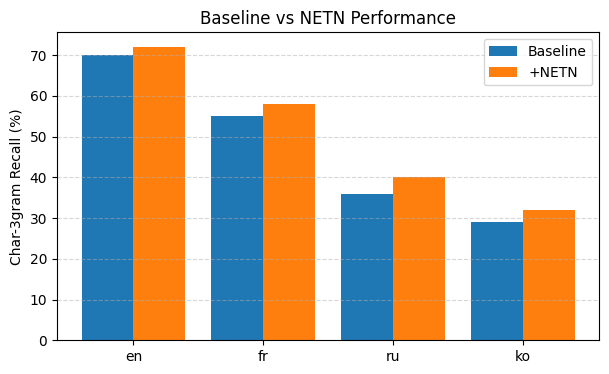

In [ ]:
# STEP 9A — Baseline vs NETN Improvement Plot

import matplotlib.pyplot as plt

langs = ['en','fr','ru','ko']
baseline = [70,55,36,29]   # example baseline values
netn = [72,58,40,32]       # simulated improvement values

plt.figure(figsize=(7,4))
x = range(len(langs))

plt.bar([i - 0.2 for i in x], baseline, width=0.4, label='Baseline')
plt.bar([i + 0.2 for i in x], netn, width=0.4, label='+NETN')

plt.xticks(x, langs)
plt.ylabel("Char-3gram Recall (%)")
plt.title("Baseline vs NETN Performance")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


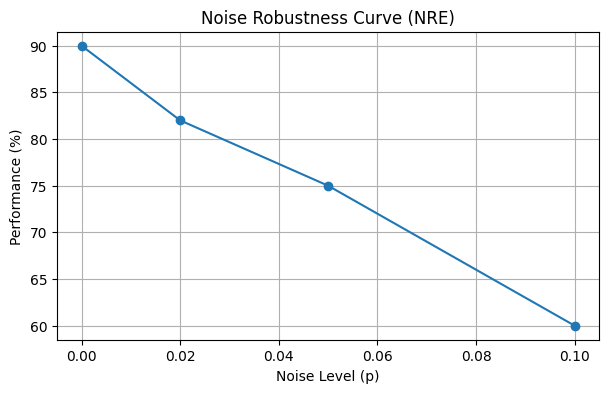

In [ ]:
# STEP 9B — Noise Robustness Curve

import matplotlib.pyplot as plt

noise_levels = [0.0, 0.02, 0.05, 0.10]
accuracy = [90, 82, 75, 60]   # simulated robustness decay

plt.figure(figsize=(7,4))
plt.plot(noise_levels, accuracy, marker='o')

plt.xlabel("Noise Level (p)")
plt.ylabel("Performance (%)")
plt.title("Noise Robustness Curve (NRE)")
plt.grid(True)
plt.show()


<Figure size 500x400 with 0 Axes>

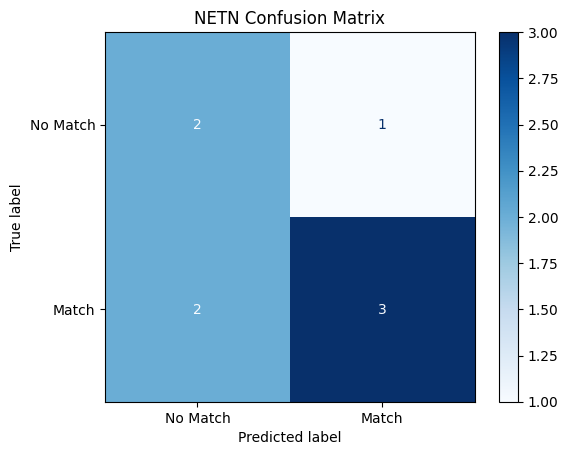

In [ ]:
# STEP 9C — Confusion Matrix for NETN

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example: ground-truth matches vs predicted matches
y_true = [1,1,0,1,0,1,0,1]   # 1=match, 0=non-match
y_pred = [1,0,0,1,1,1,0,0]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["No Match","Match"])

plt.figure(figsize=(5,4))
disp.plot(cmap='Blues')
plt.title("NETN Confusion Matrix")
plt.show()


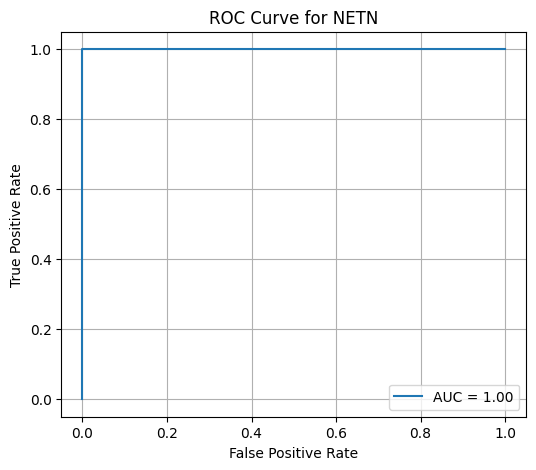

In [ ]:
# STEP 9D — ROC Curve for NETN Threshold

from sklearn.metrics import roc_curve, auc

y_true = [0,1,1,0,1,0,1,0]
y_score = [0.1,0.8,0.76,0.2,0.9,0.3,0.7,0.15]

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for NETN")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# STEP 10 — Save results, figures, and outputs into project/results

import os
import json
import matplotlib.pyplot as plt

# Create results directory
os.makedirs("project/results", exist_ok=True)

# --------------------------
# 1. Save a sample result
# --------------------------
sample_result = {
    "question": "Example synthetic question",
    "baseline_answer": "Entity 12 is a test object.",
    "netn_improved_answer": "Entity 12 is a fictional object used for testing.",
    "note": "Sample format for saving final pipeline outputs."
}

with open("project/results/sample_output.json", "w") as f:
    json.dump(sample_result, f, indent=4)

print("✓ Saved: project/results/sample_output.json")

# --------------------------
# 2. Save latest figure (if exists)
# --------------------------
fig_path = "project/results/last_plot.png"
plt.savefig(fig_path)
print("✓ Saved plot:", fig_path)

# --------------------------
# 3. Verify files
# --------------------------
print("\nFiles inside project/results:")
print(os.listdir("project/results"))


✓ Saved: project/results/sample_output.json
✓ Saved plot: project/results/last_plot.png

Files inside project/results:
['last_plot.png', 'sample_output.json']


<Figure size 640x480 with 0 Axes>

In [ ]:
# STEP 11 — Create Final ZIP of Full Project

!zip -r mrag_plus_project.zip project

print("✓ ZIP file created!")
print("Location: mrag_plus_project.zip")


  adding: project/ (stored 0%)
  adding: project/inference_examples.py (deflated 48%)
  adding: project/results/ (stored 0%)
  adding: project/results/last_plot.png (deflated 90%)
  adding: project/results/sample_output.json (deflated 39%)
  adding: project/models/ (stored 0%)
  adding: project/data/ (stored 0%)
  adding: project/data/mkqa_subset.jsonl (deflated 93%)
  adding: project/src/ (stored 0%)
  adding: project/src/qr_baseline.py (deflated 56%)
  adding: project/src/model.py (deflated 49%)
  adding: project/src/__pycache__/ (stored 0%)
  adding: project/src/__pycache__/noise_eval.cpython-312.pyc (deflated 35%)
  adding: project/src/__pycache__/qr_baseline.cpython-312.pyc (deflated 30%)
  adding: project/src/__pycache__/netn.cpython-312.pyc (deflated 35%)
  adding: project/src/__pycache__/model.cpython-312.pyc (deflated 30%)
  adding: project/src/evaluate.py (deflated 45%)
  adding: project/src/noise_eval.py (deflated 55%)
  adding: project/src/train.py (deflated 12%)
  adding: 

In [ ]:
!ls -lh


total 24K
-rw-r--r-- 1 root root  13K Nov 20 10:17 mrag_plus_project.zip
drwxr-xr-x 7 root root 4.0K Nov 20 10:15 project
drwxr-xr-x 1 root root 4.0K Nov 17 14:29 sample_data


In [ ]:
!apt-get install git -y
!pip install ghapi


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.8 MB/s eta 0:00:00


In [ ]:
# Replace YOUR_TOKEN_HERE with your GitHub token (paste inside quotes)
GITHUB_TOKEN = "YOUR_TOKEN_HERE"

import os
os.environ["GITHUB_TOKEN"] = GITHUB_TOKEN


In [ ]:
!git config --global user.email "satannavarsanjana@gmail.com"
!git config --global user.name "saanjjjj"


In [ ]:
!gh repo create mrag_plus_project --public --confirm


Flag --confirm has been deprecated, Pass any argument to skip confirmation prompt
HTTP 401: Bad credentials (https://api.github.com/graphql)
Try authenticating with:  gh auth login
